In [1]:
import numpy as np
from tqdm import tqdm

import cv2 as cv

In [2]:
%load_ext autoreload
%autoreload 2

In [17]:
# settings for LBP
radius = 3
n_points = 8 * radius

def feature_extractor(inp):
  c = np.copy(inp[0]).transpose(1,2,0)
  gray_image = np.uint8(cv.cvtColor(c, cv.COLOR_BGR2GRAY))
  sift = cv.SIFT_create()
  kp, des = sift.detectAndCompute(gray_image,None)
  if(des is None):
    return np.zeros(128)
  des = des.mean(axis=0)

  return des.ravel()

In [7]:
from dataloader import create_dataloaders

dir = "datasets/ears/images-cropped"

test = dir+"/test"
train = dir+"/train"

train_loader, val_loader, test_loader, num_classes = create_dataloaders(train, test, 8)

In [18]:


def featurize_and_labelrize(loader, l=0):
  labels_ar = []
  features_ar = []

  if(l == 0):
    l = len(test_loader)

  for b, labels in tqdm(iter(loader.dataset), total=l):
    # print( labels, b)
    labels_ar.append(labels)
    feat_in = b.unsqueeze(dim=0).numpy()
    # print(feat_in)
    features_ar.append(feature_extractor(feat_in))
    if(len(features_ar) > l):
      break
  
  return labels_ar, features_ar

labels_ar, features_ar = featurize_and_labelrize(test_loader, 30)

100%|██████████| 30/30 [00:00<00:00, 45.39it/s]


In [19]:
from sklearn.metrics import pairwise

def calculate_accuracy(features, labels):
    similarity_matrix = pairwise.cosine_distances(features)
    np.fill_diagonal(similarity_matrix, np.inf)
    predicted = labels[np.argmin(similarity_matrix, axis=0)]

    return np.mean(predicted == labels), np.sum(predicted == labels), similarity_matrix

mean score: 0.06451612903225806
 predicted: 2/31


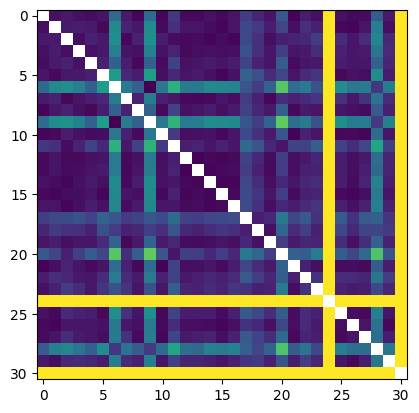

In [20]:
f = np.array(features_ar).reshape(len(features_ar), -1)
l = np.array(labels_ar)
mmean, msum, matrix = calculate_accuracy(features=f, labels=l)

import matplotlib.pyplot as plt

print(f"mean score: {mmean}\n predicted: {msum}/{len(features_ar)}")
plt.imshow(matrix)